<a href="https://colab.research.google.com/github/steinhaug/stable-diffusion/blob/main/tool/lama_cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Todo: Get the manuall Lama Python inference up and running programatically.

## LAMA CLEANER - Working

In [ ]:
#@title 1. Install package
#@markdown Github Project: https://github.com/Sanster/lama-cleaner
!pip3 install lama-cleaner pyngrok
!pip install kaleido cohere openai tiktoken
import torch
if torch.cuda.is_available():
    runtime = 'gpu'
else:
    runtime = 'cpu'

In [ ]:
#@title 2. Launch server with ngrok
from IPython.display import display, clear_output

#@markdown # Settings

init_model = 'lama' #@param ['lama', 'sd1.5', 'paint_by_example']

#@markdown Get a free [ngrok](https://ngrok.com/) account and copy your authtoken [here](https://dashboard.ngrok.com/get-started/your-authtoken).

port = 4242

ngrok_authtoken = '2MrDZfzZ6Kl1Hu3qjpNUEBvf4sF_38X9LbhY2oyf1ukBa3wWV' #@param {type: 'string'}
!ngrok authtoken $ngrok_authtoken

from pyngrok import ngrok
public_url = ngrok.connect(port).public_url

clear_output();
print(f" ")
print(f"ngrok server url: {public_url}.")
print(f"Wait for 'Running on IP' links appear before clicking.")
print(f" ")
print(f" - - - - - - - - - - - ")
print(f" ")

if runtime=='gpu':
    !lama-cleaner --host 0.0.0.0 --port $port --model $init_model
else:
    !lama-cleaner --device cpu --host 0.0.0.0 --port $port --model $init_model

## LAMA PYTHON - NOT WORKING

### prereq

In [ ]:
import torch
import torchvision
import torchaudio
import torchtext

print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("torchaudio version:", torchaudio.__version__)
print("torchtext version:", torchtext.__version__)


In [ ]:
!pip install virtualenv

In [ ]:
import os
import sys
import subprocess
import virtualenv

# Specify the desired name and location for your virtual environment
venv_name = 'myVirtual'
venv_path = '/content/.myVirtual.venv'

# Create the virtual environment
subprocess.check_call([sys.executable, '-m', 'virtualenv', venv_path])

# Activate the virtual environment
activate_script = venv_path + '/Scripts/activate' if sys.platform == 'win32' else venv_path + '/bin/activate'
subprocess.call(activate_script, shell=True)

# Ensure pip is available within the virtual environment
subprocess.check_call(['pip', 'install', 'pip'])

# Uninstall existing PyTorch (if necessary)
subprocess.call(['pip', 'uninstall', 'torch', '-y'])

# Install the desired version of PyTorch
#subprocess.call(['pip', 'install', 'torch==1.8.0'])

print('Complete')


### contin

In [ ]:
%cd /content
!git clone https://github.com/advimman/lama.git
%cd lama
!pip install wldhx.yadisk-direct


/content
Cloning into 'lama'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 399 (delta 94), reused 69 (delta 69), pack-reused 201
Receiving objects: 100% (399/399), 6.52 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/lama


In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  363M    0  363M    0     0   9.9M      0 --:--:--  0:00:36 --:--:--  9.8M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [ ]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 33.0 MB/s eta 0:00:00


In [ ]:
#@title first
print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Init mask-drawing code


In [ ]:
%cd /content/lama
fname = None
# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

/content/lama


Saving wpz-yoloselfie.00011_lp_crop.png to wpz-yoloselfie.00011_lp_crop.png
Will use ./data_for_prediction/wpz-yoloselfie.00011_lp_crop.png for inpainting


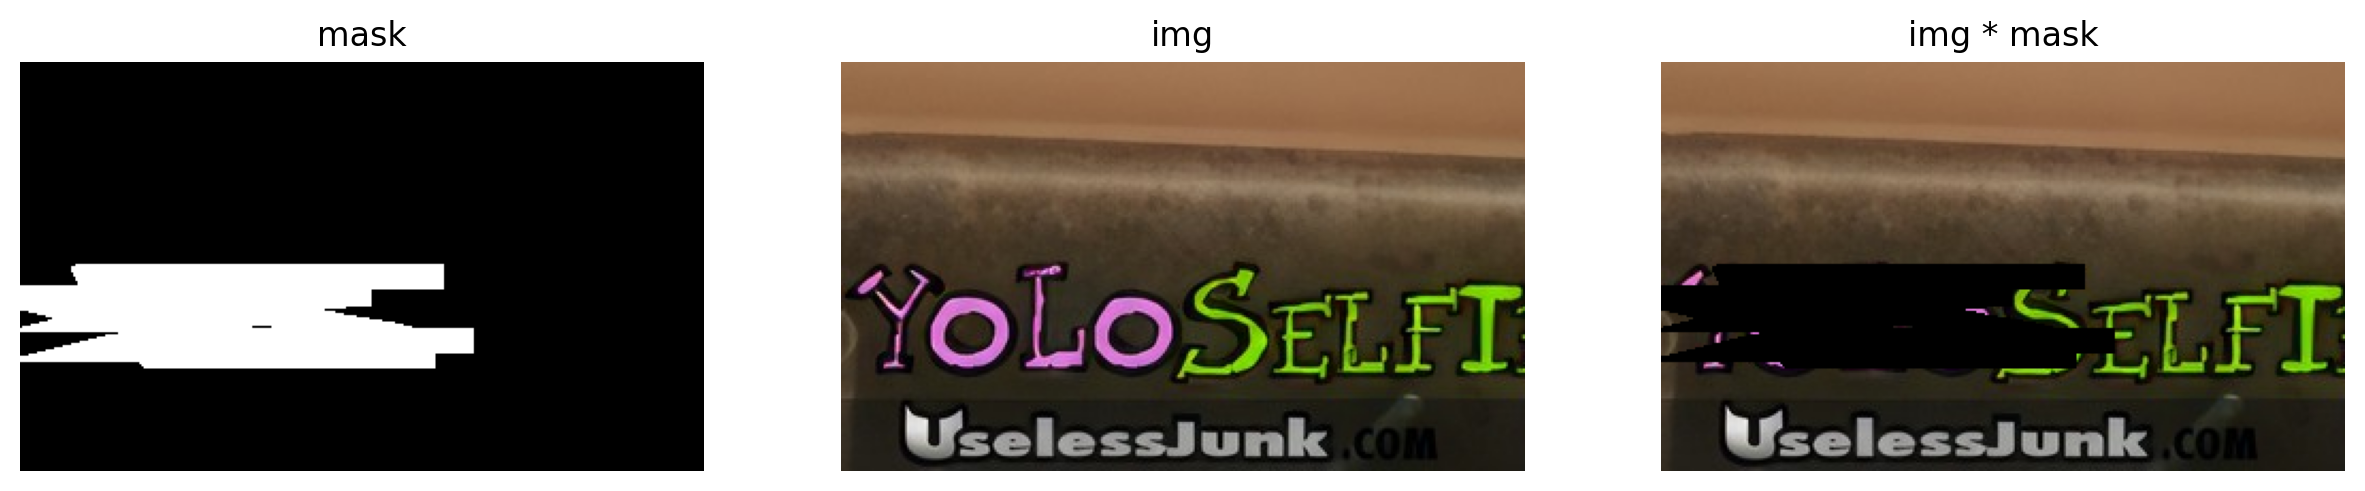

Run inpainting
Traceback (most recent call last):
  File "/content/lama/bin/predict.py", line 32, in <module>
    from saicinpainting.training.trainers import load_checkpoint
  File "/content/lama/saicinpainting/training/trainers/__init__.py", line 3, in <module>
    from saicinpainting.training.trainers.default import DefaultInpaintingTrainingModule
  File "/content/lama/saicinpainting/training/trainers/default.py", line 10, in <module>
    from saicinpainting.training.modules.fake_fakes import FakeFakesGenerator
  File "/content/lama/saicinpainting/training/modules/fake_fakes.py", line 2, in <module>
    from kornia import SamplePadding
ImportError: cannot import name 'SamplePadding' from 'kornia' (/usr/local/lib/python3.10/dist-packages/kornia/__init__.py)


FileNotFoundError: ignored

In [ ]:
#@title Draw a Mask, Press Finish, Wait for Inpainting

if fname is None:
  from google.colab import files
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

shutil.rmtree('./data_for_prediction', ignore_errors=True)
!mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None

In [ ]:
#!pip uninstall kornia -y
#!pip install kornia --no-dependencies
#!pip install kornia
!pip install kornia-rs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00


In [ ]:
import torch
from kornia import SamplePadding
from kornia.augmentation import RandomAffine, CenterCrop


ImportError: ignored

In [ ]:
import kornia

kornia_version = kornia.__version__
print("kornia version:", kornia_version)

kornia version: 0.6.12


In [ ]:
#!pip install pytorch-lightning
#!pip install kornia
#!pip install hydra-core
#!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.0 MB/s eta 0:00:00


## anything

In [ ]:
!curl https://pyenv.run | bash


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0    381      0 --:--:-- --:--:-- --:--:--   381
Cloning into '/root/.pyenv'...
remote: Enumerating objects: 1131, done.
remote: Counting objects: 100% (1131/1131), done.
remote: Compressing objects: 100% (682/682), done.
remote: Total 1131 (delta 641), reused 609 (delta 318), pack-reused 0
Receiving objects: 100% (1131/1131), 568.20 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (641/641), done.
Cloning into '/root/.pyenv/plugins/pyenv-doctor'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 38.70 KiB | 4.30 MiB/s, done.
Cloning into '/root/.pyenv/plugins/pyenv-update'...
remote: Enumerating objects: 10, done.
remote: Coun

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
!apt-get install -y make build-essential libssl-dev zlib1g-dev libbz2-dev libreadline-dev libsqlite3-dev wget curl llvm libncurses5-dev libncursesw5-dev xz-utils tk-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libbz2-dev is already the newest version (1.0.8-2).
libbz2-dev set to manually installed.
libreadline-dev is already the newest version (8.0-4).
libreadline-dev set to manually installed.
make is already the newest version (4.2.1-1.2).
make set to manually installed.
tk-dev is already the newest version (8.6.9+1).
build-essential is already the newest version (12.8ubuntu1.1).
curl is already the newest version (7.68.0-1ubuntu2.18).
libncurses5-dev is already the newest version (6.2-0ubuntu2.1).
libsqlite3-dev is already the newest version (3.31.1-4ubuntu0.5).
libsqlite3-dev set to manually installed.
libssl-dev is already the newest version (1.1.1f-1ubuntu2.19).
wget is already the newest version (1.20.3-1ubuntu2).
xz-utils is already the newest version (5.2.4-1ubuntu1.1).
xz-utils set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu1.5).
zlib1g-dev set 

In [ ]:
!pip install virtualenv
!mkdir /content/myenv
%cd /content/myenv

!virtualenv --python=python3.8 venv
!source venv/bin/activate



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 29.4 MB/s eta 0:00:00
/content/myenv
created virtual environment CPython3.8.10.final.0-64 in 985ms
  creator CPython3Posix(dest=/content/myenv/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.8.0, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
import sys

print("Python version:")
print(sys.version)
!python --version


Python version:
3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Python 3.10.12


In [ ]:
import sys

if sys.version_info >= (3, 8):
    print("Python 3.8 or newer is installed.")
else:
    print("Python 3.8 is not installed.")


Python 3.8 or newer is installed.


In [ ]:
import sys
import subprocess

def check_python_version(python_executable):
    try:
        # Execute command to get the version
        result = subprocess.run([python_executable, "--version"], capture_output=True, text=True)
        version_output = result.stdout.strip()

        # Extract the version number
        version = version_output.split()[1]

        print(f"{python_executable}: Python version {version} is installed.")
    except FileNotFoundError:
        print(f"{python_executable}: Python is not installed.")

# List of Python executables to check
python_executables = ["python3.6", "python3.7", "python3.8", "python3.9", "python3.10", "python3.11"]

# Check each Python version
for python_executable in python_executables:
    check_python_version(python_executable)


python3.6: Python is not installed.
python3.7: Python is not installed.
python3.8: Python version 3.8.10 is installed.
python3.9: Python is not installed.
python3.10: Python version 3.10.12 is installed.
python3.11: Python is not installed.


In [ ]:
!virtualenv --python=python3.8 venv
!source venv/bin/activate


created virtual environment CPython3.8.10.final.0-64 in 242ms
  creator CPython3Posix(dest=/content/myenv/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.8.0, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
%cd /content
!git clone https://github.com/geekyutao/Inpaint-Anything.git
#%cd Inpaint-Anything


In [ ]:
%cd /content/Inpaint-Anything
!python -m pip install -e segment_anything

/content/Inpaint-Anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Inpaint-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [ ]:
!python -m pip install -r lama/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 44.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.6/144.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.9/841.9 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [ ]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached osqp-0.6.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (298 kB)


In [ ]:
#@title modules
module_versions = {
"pyyaml": None,
"tqdm": None,
"numpy": None,
"easydict": "1.9.0",
#"scikit-image": "0.17.2",
"scikit-learn": "0.24.2",
"opencv-python": None,
"tensorflow": None,
"joblib": None,
"matplotlib": None,
"pandas": None,
"albumentations": "0.5.2",
"hydra-core": "1.1.0",
"pytorch-lightning": "1.2.9",
"tabulate": None,
"kornia": "0.5.0",
"webdataset": None,
"packaging": None,
"scikit-learn": "0.24.2",
"wldhx.yadisk-direct": None
}

import importlib
import subprocess
import pkg_resources

def smartPipInstall(module_versions, doInstall=True):
    # Loop through module names and versions
    for module_name, required_version in module_versions.items():
        try:
            # Attempt to import the module
            importlib.import_module(module_name)
            print(f"Module {module_name} already installed..", end='')

            if required_version is not None:
                installed_version = pkg_resources.get_distribution(module_name).version
                print(f" ver. {installed_version}...", end='')

                if installed_version.strip() != required_version.strip():
                    print(f" reinstalling... wrong ver... Installed {installed_version} != {required_version} required...", end='')
                    if doInstall:
                        subprocess.check_call(["pip", "uninstall", "-y", f"{module_name}"])
                        print(f" uninstalled...", end='')
                        subprocess.check_call(["pip", "install", f"{module_name}=={required_version}"])
                        print(f" ver. {required_version} installed", end='')
            print(".")
        except ModuleNotFoundError:
            # Module is not installed, install it using pip
            print(f"Installing {module_name}...", end='')
            if doInstall:
                if required_version is None:
                    subprocess.check_call(["pip", "install", f"{module_name}"])
                else:
                    subprocess.check_call(["pip", "install", f"{module_name}=={required_version}"])
                print(f" ver. {required_version} installed successfully", end='')
            print(".")

smartPipInstall(module_versions, True)


Installing pyyaml... ver. None installed successfully.
Module tqdm already installed...
Module numpy already installed...
Module easydict already installed.. ver. 1.10... reinstalling... wrong ver... Installed 1.10 != 1.9.0 required... uninstalled... ver. 1.9.0 installed.
Installing scikit-learn... ver. 0.24.2 installed successfully.
Installing opencv-python... ver. None installed successfully.
Module tensorflow already installed...
Module joblib already installed...
Module matplotlib already installed...
Module pandas already installed...
Module albumentations already installed.. ver. 1.2.1... reinstalling... wrong ver... Installed 1.2.1 != 0.5.2 required... uninstalled... ver. 0.5.2 installed.
Installing hydra-core... ver. 1.1.0 installed successfully.
Installing pytorch-lightning... ver. 1.2.9 installed successfully.
Module tabulate already installed...
Module kornia already installed.. ver. 0.6.12... reinstalling... wrong ver... Installed 0.6.12 != 0.5.0 required... uninstalled... 

In [ ]:
!wget -content-disposition https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O /content/Inpaint-Anything/pretrained_models/sam_vit_h_4b8939.pth
!cp /content/lama/big-lama/models/best.ckpt /content/Inpaint-Anything/pretrained_models/best.ckpt
!cp /content/lama/big-lama/config.yaml /content/Inpaint-Anything/pretrained_models/config.yaml


In [ ]:
%cd /content/Inpaint-Anything
!python remove_anything.py \
    --input_img "/content/test/wpz-yoloselfie.00053_ll_crop.png" \
    --coords_type key_in \
    --point_coords 20 50 \
    --point_labels 1 \
    --dilate_kernel_size 15 \
    --output_dir /content/results \
    --sam_model_type "vit_h" \
    --sam_ckpt ./pretrained_models/sam_vit_h_4b8939.pth \
    --lama_config ./lama/configs/prediction/default.yaml \
    --lama_ckpt ./pretrained_models/best.ckpt

/content/Inpaint-Anything
Traceback (most recent call last):
  File "/content/Inpaint-Anything/remove_anything.py", line 9, in <module>
    from lama_inpaint import inpaint_img_with_lama
  File "/content/Inpaint-Anything/lama_inpaint.py", line 19, in <module>
    from saicinpainting.evaluation.utils import move_to_device
  File "/content/Inpaint-Anything/lama/saicinpainting/evaluation/__init__.py", line 6, in <module>
    from saicinpainting.evaluation.losses.base_loss import SSIMScore, LPIPSScore, FIDScore
  File "/content/Inpaint-Anything/lama/saicinpainting/evaluation/losses/base_loss.py", line 15, in <module>
    from .lpips import PerceptualLoss
  File "/content/Inpaint-Anything/lama/saicinpainting/evaluation/losses/lpips.py", line 15, in <module>
    from saicinpainting.utils import get_shape
  File "/content/Inpaint-Anything/lama/saicinpainting/utils.py", line 12, in <module>
    from pytorch_lightning import seed_everything
  File "/usr/local/lib/python3.10/dist-packages/pytorc

In [ ]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## LAMA PYTHON - NOT WORKING

In [ ]:
%cd /content
!git clone https://github.com/geomagical/lama-with-refiner.git
%cd lama-with-refiner
!git checkout amp_float16

/content
Cloning into 'lama-with-refiner'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 456 (delta 122), reused 98 (delta 98), pack-reused 231
Receiving objects: 100% (456/456), 6.53 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (182/182), done.
/content/lama-with-refiner
Branch 'amp_float16' set up to track remote branch 'amp_float16' from 'origin'.
Switched to a new branch 'amp_float16'


## 🦙 LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions

[[Project page](https://advimman.github.io/lama-project/)] [[GitHub](https://github.com/advimman/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]

Our model generalizes surprisingly well to much higher resolutions (~2k❗️) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.

Reference links: [[colab](https://colab.research.google.com/github/advimman/lama/blob/master/colab/LaMa_inpainting.ipynb)] [
[docs](https://lama-cleaner-docs.vercel.app/models/lama)]

In [ ]:
#@title Run this sell to set everything up
%cd /content

print('\n> Cloning the repo')
!git clone https://github.com/advimman/lama.git

print('\n> Install dependencies')
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet


print('\n> Changing the dir to:')
%cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet


print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [ ]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

In [ ]:
!pip install opencv-contrib-python

In [ ]:
!pip show torch

In [ ]:
!pip3 install opencv-python
!pip3 install opencv-python-headless

In [ ]:
!pip install pytorch-lightning

In [ ]:
#!pip install kornia -U
!pip uninstall kornia
!pip install kornia --no-dependencies

In [ ]:
!pip install hydra-core --upgrade

In [ ]:
!pip install webdataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#fname = None
source_fname = '/content/drive/MyDrive/data/blip2/yolo.jpg'
# fname = 'https://drive.google.com/file/d/1-rQstcncSf9ctjlCF7Z4QzBwkccfNZya/view?usp=drive_link'
# fname = "https://drive.google.com/file/d/1-P2pUoNQTydPjtQv9x1ykbhlu53Kf5c0/view?usp=drive_link"
# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example

display( fname )


In [ ]:
fname = 'demonstration.jpg'
predir = '/content/tmpdata'

!cp $source_fname $predir/$fname


In [ ]:
#@title Draw a Mask, Press Finish, Wait for Inpainting

#shutil.rmtree('./data_for_prediction', ignore_errors=True)
#!mkdir data_for_prediction

#copyfile(source_fname, f'./data_for_prediction/{fname}')
#os.remove(fname)
%cd /content/lama

fname = predir + '/demonstration.jpg'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('continue next cell')

In [ ]:
print( PYTHONPATH )

In [ ]:
!wget https://github.com/Sanster/models/releases/download/add_big_lama/big-lama.pt -O /content/big-lama.pt

In [ ]:
%cd /content/lama
!python3 bin/predict.py model.path=/content/big-lama indir=/content/data_for_prediction outdir=/content/output dataset.img_suffix=.jpg > /dev/null

In [ ]:
print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None